### 1 - Import test data

In [3]:
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
import os
tqdm.pandas()
import numpy as np
import pandas as pd
import pandas_ta as ta
from binance.client import Client
from tqdm import tqdm

# Initialize Binance client
client = Client()

def fetch_klines_for_ticker(ticker, interval, start_time):
    """
    Fetch historical klines (CloseV data) from Binance for a specific ticker.
    """
    df = client.get_historical_klines(ticker, interval, start_time)
    columns = [
        'Open time', 'Open', 'High', 'Low', 'Close', 'Volume1',
        'Close time', 'Volume', 'Adj Close',
        'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'
    ]
    df = pd.DataFrame(df, columns=columns)

    # Drop unnecessary columns
    df = df.drop(['Close time', 'Volume1', 'Taker buy base asset volume', 
                  'Taker buy quote asset volume', 'Ignore'], axis='columns')

    # Convert columns to numeric
    df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')

    # Convert 'Open time' to datetime and set it as the index
    df['Datetime'] = pd.to_datetime(df['Open time'], unit='ms')
    df = df.drop(['Open time'], axis='columns')
    df.set_index('Datetime', inplace=True)
    df.index = df.index.tz_localize('UTC')

    # Calculate technical indicators
    df["EMA_slow"] = ta.ema(df['Close'], length=50)
    df["EMA_fast"] = ta.ema(df['Close'], length=40)
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=7)

    # Remove rows that do not have enough data for indicators
    df = df[51:]
    
    return df

def fetch_multiple_tickers(tickers, interval="1m", days_ago="5 day ago UTC"):
    """
    Fetch historical data for multiple tickers.
    
    Parameters:
        tickers (str): Comma-separated ticker symbols (e.g., "BTCUSDT,ETHUSDT").
        interval (str): Time interval for the kline data (e.g., "1m" for 1-minute).
        days_ago (str): The starting time for historical data (e.g., "5 day ago UTC").
        
    Returns:
        dict: A dictionary where keys are ticker symbols and values are DataFrames of the CloseV data.
    """
    tickers_list = [ticker.strip() for ticker in tickers.split(",")]
    ticker_data = {}
    
    for ticker in tqdm(tickers_list):
        df = fetch_klines_for_ticker(ticker, interval, days_ago)
        ticker_data[ticker] = df
        
    return ticker_data

def apply_technical_indicators(df):
    df["EMA_slow"] = ta.ema(df.Close, length=200)
    df["EMA_fast"] = ta.ema(df.Close, length=150)
    df['RSI'] = ta.rsi(df.Close, length=18)
    my_bbands = ta.bbands(df.Close, length=20, std=2.0)
    df['ATR'] = ta.atr(df.High, df.Low, df.Close, length=15)
    df = df.join(my_bbands)
    return df

def ema_signal(df, current_candle, backcandles):
    df_slice = df.reset_index().copy()
    # Get the range of candles to consider
    start = max(0, current_candle - backcandles)
    end = current_candle
    relevant_rows = df_slice.iloc[start:end]

    # Check if all EMA_fast values are below EMA_slow values
    if all(relevant_rows["EMA_fast"] < relevant_rows["EMA_slow"]):
        return 1
    elif all(relevant_rows["EMA_fast"] > relevant_rows["EMA_slow"]):
        return 2
    else:
        return 0
    
def update_dataframe_ema_signal(df):
    df.reset_index(inplace=True)
    df['EMASignal'] = df.progress_apply(lambda row: ema_signal(df, row.name, 7) if row.name >= 20 else 0, axis=1)
    return df

def total_signal(df, current_candle, backcandles):
    c_BB_width =  (abs(df['BBL_20_2.0'][current_candle] - df['BBU_20_2.0'][current_candle]) / df['BBL_20_2.0'][current_candle]) > 0.0015
    if (ema_signal(df, current_candle, backcandles)==2
        and df.Close[current_candle]<=df['BBL_20_2.0'][current_candle]
        and c_BB_width
        and all(df.iloc[current_candle-backcandles:current_candle]["RSI"] >= 30)
        ):
            return 2
    if (ema_signal(df, current_candle, backcandles)==1
        and df.Close[current_candle]>=df['BBU_20_2.0'][current_candle]
        and c_BB_width
        and all(df.iloc[current_candle-backcandles:current_candle]["RSI"] <= 70)
        ):
    
            return 1
    return 0

def add_total_signal(df):
    df['TotalSignal'] = df.progress_apply(lambda row: total_signal(df, row.name, 7), axis=1)
    return df

def candles_trend_signal(df, current_candle, backcandles):
    """
    This function calculates the total signal based on the following criteria:
    - If the previous 'backcandles' candles are all above the corresponding EMA values, it returns 2 (bullish).
    - If the previous 'backcandles' candles are all below the corresponding EMA values, it returns 1 (bearish).
    - Otherwise, it returns 0 (neutral).
    
    Parameters:
    df (DataFrame): DataFrame containing the stock data with 'High', 'Low', and 'EMA_fast' columns.
    current_candle (int): The index of the current candle.
    backcandles (int): The number of previous candles to check.
    
    Returns:
    int: Signal value (2 for bullish, 1 for bearish, 0 for neutral).
    """
    bullish = True
    bearish = True

    for i in range(current_candle - backcandles, current_candle+1):
        if i < 0:
            return 0  # Not enough data to evaluate
        
        if df.High[i] <= df['EMA_fast'][i] or df.Low[i] <= df['EMA_fast'][i]:
            bullish = False
        
        if df.High[i] >= df['EMA_fast'][i] or df.Low[i] >= df['EMA_fast'][i]:
            bearish = False

    if bullish:
        return 2
    if bearish:
        return 1
    return 0

def update_total_signal(df, backcandles=5):
    # Calculate signal for all candles
    df['candle_trend_signal'] = [candles_trend_signal(df, x, backcandles=backcandles) if x >= backcandles else 0 for x in tqdm(df.index)]
    df['TotalSignal'] = df.apply(lambda row: row['TotalSignal'] if row['TotalSignal'] == row['candle_trend_signal'] else 0, axis=1)
    return df

In [4]:
tickers = "BTCUSDT, ETHUSDT, BNBUSDT, AVAXUSDT"
dataframes = fetch_multiple_tickers(tickers, interval=Client.KLINE_INTERVAL_1MINUTE, days_ago="5 day ago UTC")

for ticker, df in dataframes.items():  # Iterate over dictionary values
    print(f"Working on dataframe for {ticker}...")
    df = apply_technical_indicators(df)
    df = update_dataframe_ema_signal(df)
    df = add_total_signal(df)
    df = update_total_signal(df)
    dataframes[ticker] = df 

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:15<00:00,  3.78s/it]


Working on dataframe for BTCUSDT...


100%|██████████| 7149/7149 [00:00<00:00, 7178.68it/s]


Working on dataframe for ETHUSDT...


100%|██████████| 7149/7149 [00:00<00:00, 7224.25it/s]


Working on dataframe for BNBUSDT...


100%|██████████| 7149/7149 [00:00<00:00, 7198.51it/s]


Working on dataframe for AVAXUSDT...


100%|██████████| 7149/7149 [00:00<00:00, 7277.97it/s]


In [5]:
sum([frame["TotalSignal"].value_counts() for frame in dataframes.values()])

TotalSignal
0    28185
1      205
2      206
Name: count, dtype: int64

In [6]:
from backtesting import Strategy
from backtesting import Backtest

def SIGNAL():
    return df.TotalSignal

class MyStrat(Strategy):
    mysize = 0.1
    slcoef = 2
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        
        for trade in self.trades: 
            if trade.is_long: 
                trade.sl = max(trade.sl or -np.inf, self.data.Close[-1] - slatr)
            else:
                trade.sl = min(trade.sl or np.inf, self.data.Close[-1] + slatr) 

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            self.buy(sl=sl1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            self.sell(sl=sl1, size=self.mysize)

/home/nitin/Downloads/Project/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [7]:
results = []

# Loop over the values of the dictionary, which are the DataFrames
for df in dataframes.values():
    bt = Backtest(df, MyStrat, cash=250000, margin=1/10, commission=0.0002)
    stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(8, 31)],
                        maximize='Return [%]', max_tries=3000,
                        random_state=0,
                        return_heatmap=True)
    results.append(stats)


/tmp/ipykernel_53575/157358564.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

/tmp/ipykernel_53575/157358564.py:5: UserWarning:                 

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

/tmp/ipykernel_53575/157358564.py:5: UserWarning:                 

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

/tmp/ipykernel_53575/157358564.py:5: UserWarning:                 

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



In [8]:
def check_signals_accuracy(df, trend_window):
    # Shift the 'Close' column for the trend window
    for i in range(1, trend_window + 1):
        df[f'Close_{i}'] = df['Close'].shift(-i)

    # Initialize columns to check trend correctness
    df['Correct'] = 0

    # For bearish signals (1), check if prices are lower for the trend_window period
    df.loc[(df['TotalSignal'] == 1) & (df[[f'Close_{i}' for i in range(1, trend_window + 1)]].min(axis=1) < df['Close']), 'Correct'] = 1

    # For bullish signals (2), check if prices are higher for the trend_window period
    df.loc[(df['TotalSignal'] == 2) & (df[[f'Close_{i}' for i in range(1, trend_window + 1)]].max(axis=1) > df['Close']), 'Correct'] = 1

    # Return the count of correct signals
    correct_signals = df['Correct'].sum()
    total_signals = len(df[df['TotalSignal'] != 0])  # Only count non-zero signals

    return correct_signals, total_signals

# Iterate through all DataFrames and calculate accuracy for trend windows from 1 to 10
results_ = {}

for trend_window in range(1, 30):  # Iterate from trend_window 1 to 10
    total_correct_signals = 0
    total_signals = 0

    for df in dataframes.values():
        correct_signals, total_signals_in_df = check_signals_accuracy(df, trend_window)
        total_correct_signals += correct_signals
        total_signals += total_signals_in_df

    # Calculate the overall accuracy for the current trend window
    if total_signals > 0:
        accuracy = (total_correct_signals / total_signals) * 100
        results_[trend_window] = accuracy
        print(f"Trend Window: {trend_window}, Accuracy: {accuracy:.2f}%")
    else:
        print(f"Trend Window: {trend_window}, No valid signals found.")
        results_[trend_window] = None


Trend Window: 1, Accuracy: 50.12%
Trend Window: 2, Accuracy: 65.45%
Trend Window: 3, Accuracy: 70.56%
Trend Window: 4, Accuracy: 74.45%
Trend Window: 5, Accuracy: 78.35%
Trend Window: 6, Accuracy: 80.29%
Trend Window: 7, Accuracy: 81.27%
Trend Window: 8, Accuracy: 82.24%
Trend Window: 9, Accuracy: 83.45%
Trend Window: 10, Accuracy: 85.16%
Trend Window: 11, Accuracy: 85.89%
Trend Window: 12, Accuracy: 86.37%
Trend Window: 13, Accuracy: 86.86%
Trend Window: 14, Accuracy: 88.08%
Trend Window: 15, Accuracy: 88.56%
Trend Window: 16, Accuracy: 89.29%
Trend Window: 17, Accuracy: 89.78%
Trend Window: 18, Accuracy: 90.02%
Trend Window: 19, Accuracy: 90.51%
Trend Window: 20, Accuracy: 90.51%
Trend Window: 21, Accuracy: 90.51%
Trend Window: 22, Accuracy: 90.75%
Trend Window: 23, Accuracy: 91.00%
Trend Window: 24, Accuracy: 91.00%
Trend Window: 25, Accuracy: 91.00%
Trend Window: 26, Accuracy: 91.00%
Trend Window: 27, Accuracy: 91.24%
Trend Window: 28, Accuracy: 91.48%
Trend Window: 29, Accuracy: 9

In [18]:
import pandas as pd
import plotly.graph_objects as go

# Sample DataFrame with OHLC (Open, High, Low, Close) and signals
# Replace this with your full 100-candlestick DataFrame

# Split the data into 10 segments of 10 candlesticks each
segments = [df[i:i+300] for i in range(0, len(df), 300)]

# Create separate charts for each segment and open them in the browser
for idx, segment in enumerate(segments):
    # Create the base candlestick chart
    fig = go.Figure()

    # Add candlestick chart using OHLC data
    fig.add_trace(go.Candlestick(
        x=segment.index,
        open=segment['Open'],
        high=segment['High'],
        low=segment['Low'],
        close=segment['Close'],
        name='Candlesticks'
    ))

    # Plot Buy (Bullish) signals (TotalSignal == 2)
    fig.add_trace(go.Scatter(
        x=segment[segment['TotalSignal'] == 2].index, 
        y=segment[segment['TotalSignal'] == 2]['Close'], 
        mode='markers', 
        name='Bullish (Buy)', 
        marker=dict(symbol='triangle-up', color='green', size=10)
    ))

    # Plot Sell (Bearish) signals (TotalSignal == 1)
    fig.add_trace(go.Scatter(
        x=segment[segment['TotalSignal'] == 1].index, 
        y=segment[segment['TotalSignal'] == 1]['Close'], 
        mode='markers', 
        name='Bearish (Sell)', 
        marker=dict(symbol='triangle-down', color='red', size=10)
    ))

    # Customize the layout
    fig.update_layout(
        title=f'Candlestick Chart with Trading Signals (Segment {idx+1})',
        xaxis_title='Time',
        yaxis_title='Price',
        showlegend=True,
        template="plotly_white"
    )

    # Show the plot in the browser
    fig.show(renderer="browser")


In [113]:
agg_returns = sum([r["Return [%]"] for r in results])
num_trades = sum([r["# Trades"] for r in results])
max_drawdown = min([r["Max. Drawdown [%]"] for r in results])
avg_drawdown = sum([r["Avg. Drawdown [%]"] for r in results]) / len(results)

win_rate = sum([r["Win Rate [%]"] for r in results]) / len(results)
best_trade = max([r["Best Trade [%]"] for r in results])
worst_trade = min([r["Worst Trade [%]"] for r in results])
avg_trade = sum([r["Avg. Trade [%]"] for r in results]) / len(results)
max_trade_duration = max([r["Max. Trade Duration"] for r in results])
avg_trade_duration = sum([r["Avg. Trade Duration"] for r in results]) / len(results)

print(f"Aggregated Returns: {agg_returns:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Average Drawdown: {avg_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Best Trade: {best_trade:.2f}%")
print(f"Worst Trade: {worst_trade:.2f}%")
print(f"Average Trade: {avg_trade:.2f}%")
print(f"Maximum Trade Duration: {max_trade_duration} days")
print(f"Average Trade Duration: {avg_trade_duration:.2f} days")


Aggregated Returns: 16.35%
Number of Trades: 169.0
Maximum Drawdown: -13.54%
Average Drawdown: -1.70%
Win Rate: 39.38%
Best Trade: 8.17%
Worst Trade: -5.10%
Average Trade: 0.10%
Maximum Trade Duration: 90.0 days
Average Trade Duration: 12.40 days


In [114]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the last value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    last_value = equity.iloc[-1]
    padding = [last_value] * (max_length - len(equity))
    padded_equity = equity.tolist() + padding
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

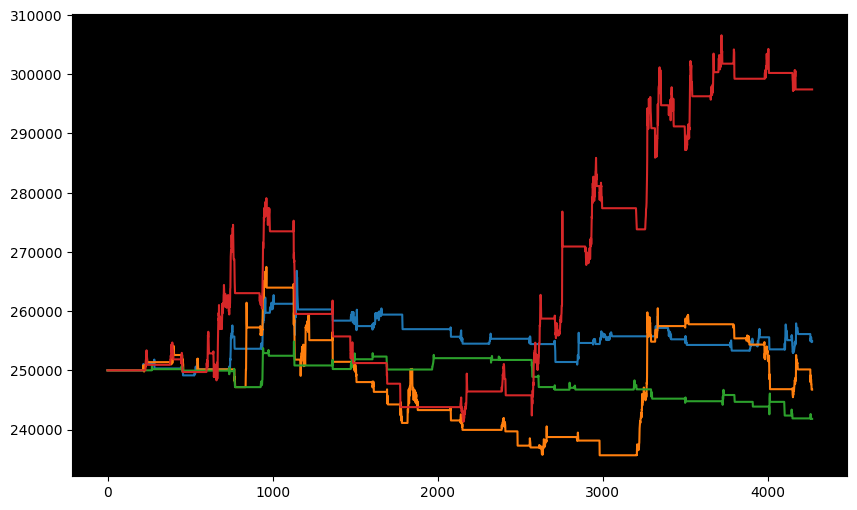

In [115]:
import matplotlib.pyplot as plt

equity_df.plot(kind='line', figsize=(10, 6), legend=False).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('black')

In [68]:
[r["Return [%]"] for r in results]

[0.9332641473708906,
 -1.6162017502574018,
 0.9702335444817436,
 -3.1156218682677017]